# `ModelForge`
### Amortise your Forwards Models

This example is deigned to give a quick overview of how to use `ModelForge` to amortise a forward model.

The main classes we will use are `MLPAmortisedModel`, and `SupervisedAmortiser`

We will use a slightly more complex example, showing how to jointly amortise the recovery of both stellar position (via tip-tilt) and stellar flux. 

As an example we will use the simplest MLP model, with a depth of zero, plus the `ModelForge` `SimpleLinear` layer used as a learning rate filter!

In [1]:
# Packages
import jax
import zodiax as zdx
import equinox as eqx
import dLux as dl
import optax

# Modules
from jax import numpy as np, random as jr, tree_util as jtu
from dLux import layers as dll, utils as dlu
import matplotlib.pyplot as plt
from matplotlib import colormaps
from tqdm.notebook import tqdm

# Model Forge
import ModelForge as forge

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 96
%matplotlib inline

In [2]:
import itertools

# NOTE: Ive kept this in the notebook because its not quite robust enough yet
def build_hyper_trainer(joint_model, **kwargs):
    """This is just a co-pilot clever way to automate hyper param creation, lr must be
    supplied. All inputs must be iterables. Not lr will always appear as a hyper
    parameter."""
    fmodel = joint_model.fmodel
    params = joint_model.params

    # Ensure there is a lr
    if "lr" not in kwargs.keys():
        raise ValueError("lr must be supplied")

    # Iterate over all combinations of hyper parameters
    keys, values = list(kwargs.keys()), list(kwargs.values())

    # Ensure we know what all the hyper parameters are
    for key in keys:
        if key not in ["lr", "depth", "width"]:
            raise ValueError(f"Unknown hyper parameter {key}")

    optimisers, optims, hypers = [], [], []
    for combination in itertools.product(*values):
        # Build hyper parameters into a dict
        hyperparams = dict(zip(keys, combination))

        # Save values to list
        hypers.append(hyperparams)

        # Built the optimiser's-optimiser
        optims.append(optax.adam(hyperparams["lr"]))

        # Build the optimiser
        # Manually feed in the hyper parameters, because dict.pop removes value even
        # after its been passed into the hypers list... Fuck mutability
        optimisers.append(
            forge.MLPAmortisedModel(
                fmodel, params, depth=hyperparams["depth"], width=hyperparams["width"]
            ).optimiser
        )

    # Return the trainer
    return forge.HyperTrainer(joint_model, optimisers, optims, hypers)

## Make The Forwards Model

In [3]:
# Source parameters
wavelengths = 1e-6 * np.linspace(1.0, 1.2, 5)
source = dl.PointSource(wavelengths, flux=1e4)

# Wavefront parameters
wf_npix = 256
aper_diam = 2.4

# Generate an aperture manually
coords = dlu.pixel_coords(5 * wf_npix, 2.4)
spider_angles = 45 + np.linspace(0, 360, 4, endpoint=False)
outer = dlu.circle(coords, aper_diam / 2)
inner = dlu.circle(coords, 0.3, True)
spiders = dlu.spider(coords, 0.05, spider_angles)
aperture = dlu.combine([outer, inner, spiders], 5)

# Generate zernike aberrations
coords = dlu.pixel_coords(wf_npix, 2.4)
zernikes = np.arange(2, 10)
# zernikes = np.arange(2, 4)
basis = np.array([1e-9 * dlu.zernike(i, coords, aper_diam) for i in zernikes])
coeffs = jr.normal(jr.PRNGKey(0), (len(zernikes),))

# PSF parameters
psf_wf_npix = 64
sampling = 3  # ie 1.5x Nyquist
psf_oversample = 2
fringe_size = dlu.fringe_size(wavelengths, aper_diam).min()
psf_pix_scale = 1.22 * dlu.rad2arcsec(fringe_size) / sampling

# Construct optics & Telescope
layers = [("aperture", dll.BasisOptic(aperture, basis, coeffs, normalise=True))]
optics = dl.AngularOptics(
    wf_npix, aper_diam, layers, psf_wf_npix, psf_pix_scale / psf_oversample
)
fmodel = dl.Telescope(optics, source)

## Examine

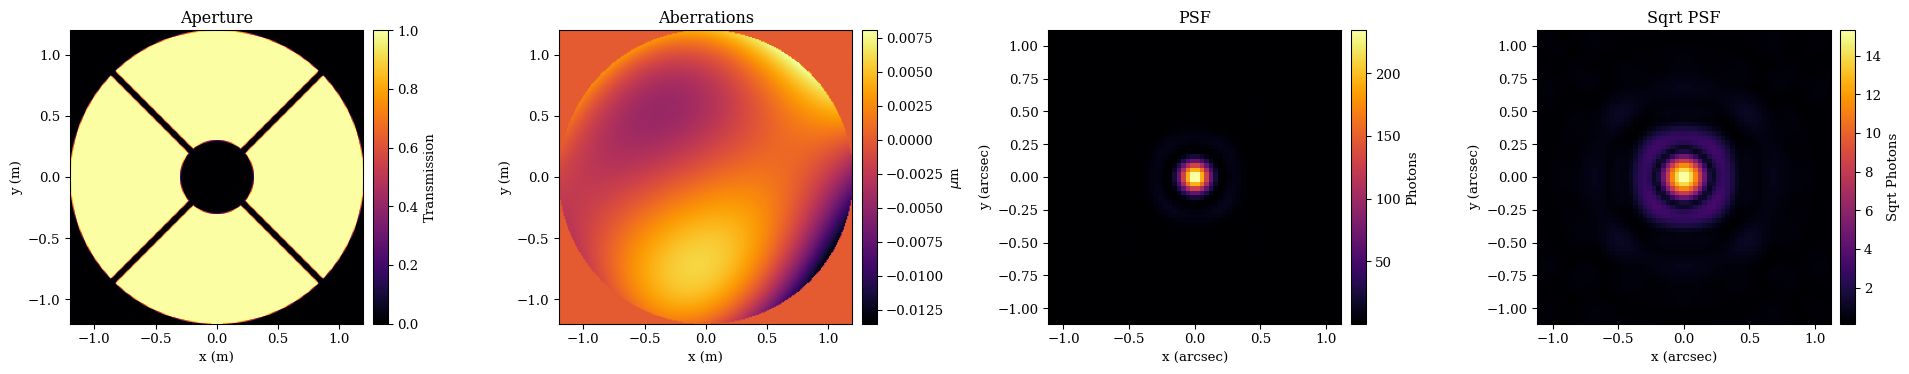

In [4]:
from ModelForge import plotting as p

fig, axes = p.plot_grid_2d(1, 4)

# Aperture plots
r = aper_diam / 2
extent = (-r, r, -r, r)

axes[0].set(xlabel="x (m)", ylabel="y (m)", title="Aperture")
im = axes[0].imshow(optics.transmission, extent=extent)
p.add_cbar(fig, axes[0], im, label="Transmission")

axes[1].set(xlabel="x (m)", ylabel="y (m)", title="Aberrations")
im = axes[1].imshow(1e6 * optics.eval_basis(), extent=extent)
p.add_cbar(fig, axes[1], im, label="$\mu$m")

# PSF plots
psf = fmodel.model()
r = psf_pix_scale * psf_wf_npix / 2
extent = (-r, r, -r, r)

axes[2].set(xlabel="x (arcsec)", ylabel="y (arcsec)", title="PSF")
im = axes[2].imshow(psf, extent=extent)
p.add_cbar(fig, axes[2], im, label="Photons")

axes[3].set(xlabel="x (arcsec)", ylabel="y (arcsec)", title="Sqrt PSF")
im = axes[3].imshow(psf**0.5, extent=extent)
p.add_cbar(fig, axes[3], im, label="Sqrt Photons")
fig.tight_layout()

# Generate Samples

Two options here, a single parameter and multiple parameters, just to show that they both work

In [11]:
# Example one: A single parameter
params = ["coefficients"]
joint_model = forge.MLPAmortisedModel(fmodel, params, depth=2, init_scale=1e-1)

# Generate training and testing distributions
truth_prior = [forge.Normal(mu=0, sigma=10, bc_shape=coeffs.shape)]
train_prior = [forge.Normal(mu=0, sigma=50, bc_shape=coeffs.shape)]

In [12]:
# # Example 2: Two parameters
# params = ["coefficients", "flux"]
# joint_model = forge.MLPAmortisedModel(fmodel, params, depth=2, init_scale=1e-1)

# # Generate training and testing distributions
# truth_prior = [
#     forge.Normal(mu=0, sigma=10, bc_shape=coeffs.shape),
#     forge.Normal(mu=1e4, sigma=100)
# ]
# train_prior = [
#     forge.Normal(mu=0, sigma=50, bc_shape=coeffs.shape),
#     forge.Normal(mu=1e4, sigma=100)
# ]

## Examine the initialisation performance

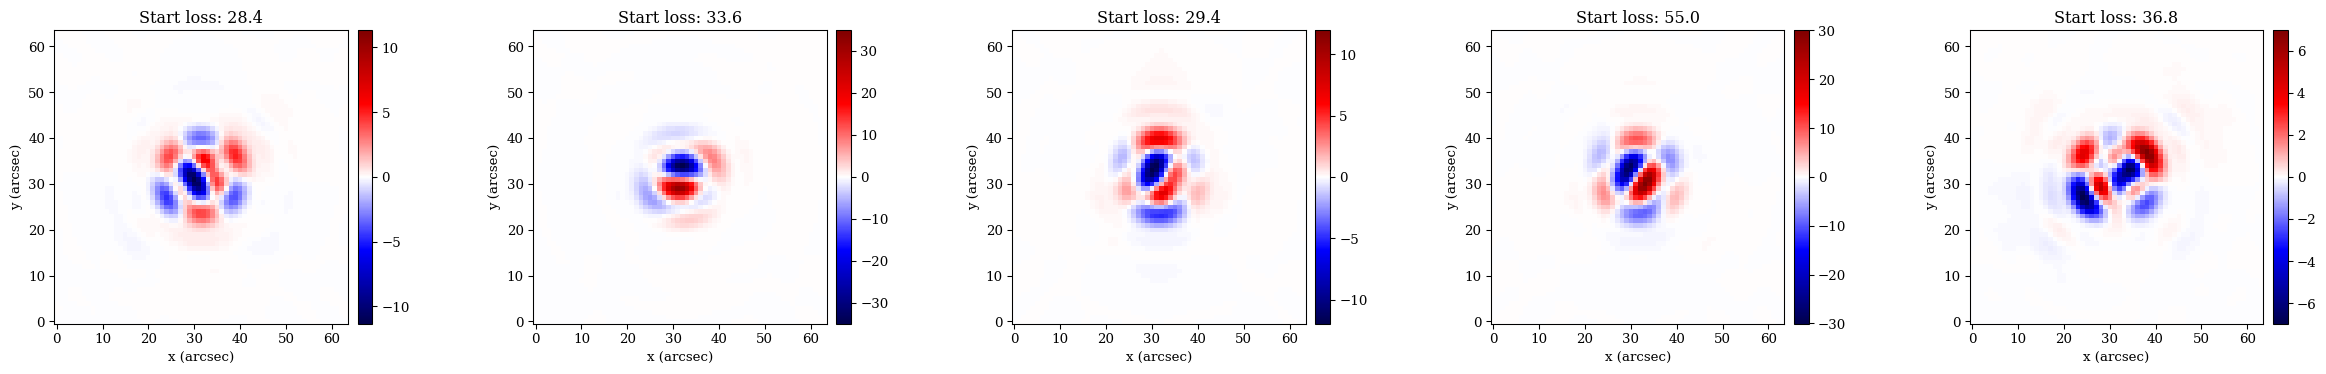

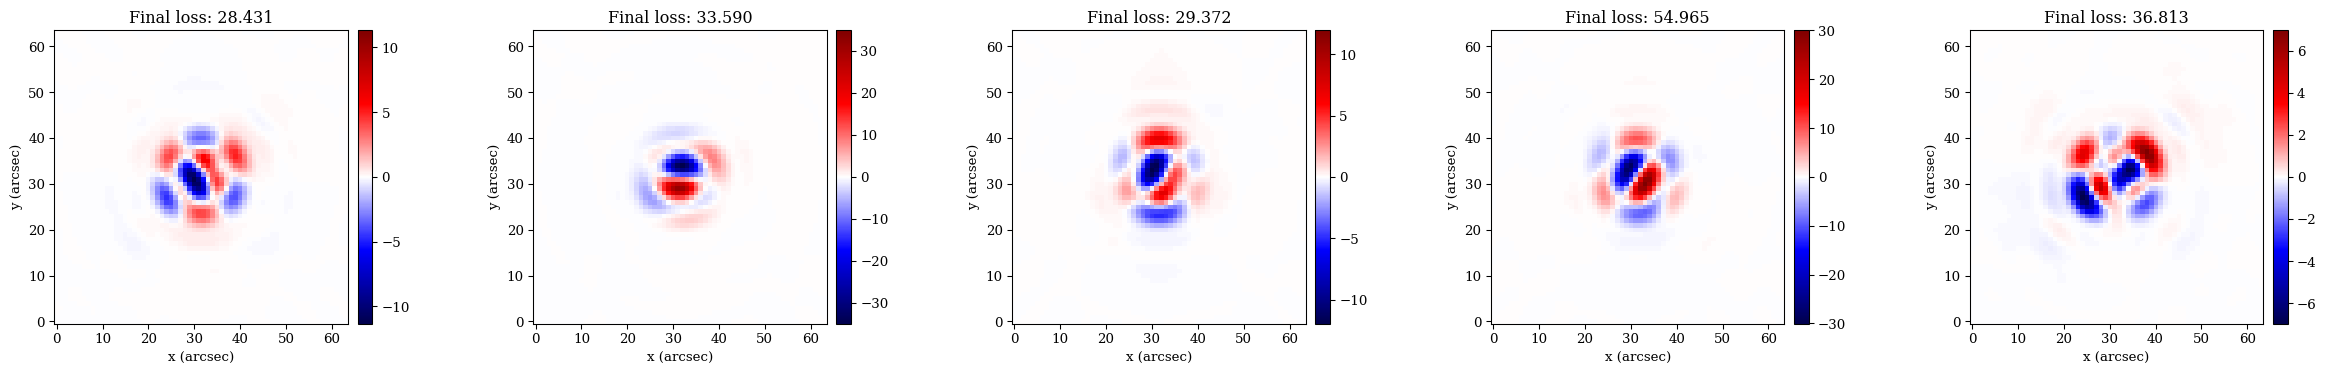

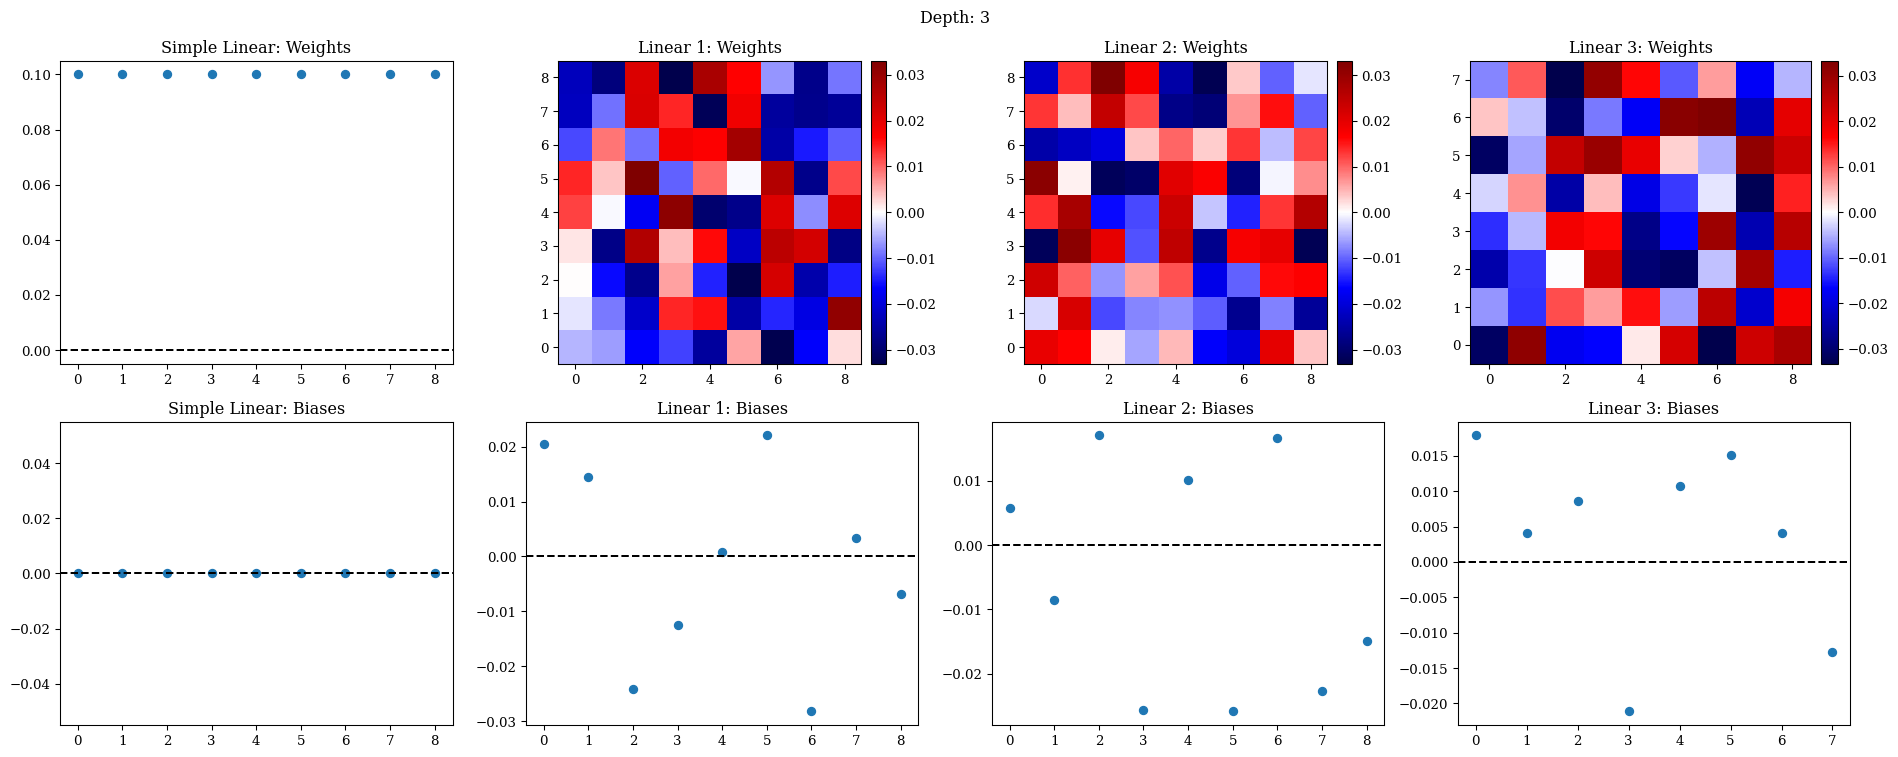

In [13]:
# We can examine the initialisation conditions here if we want
forge.examine_predictions(joint_model, truth_prior, truth_prior, 1, 5)
forge.visualise_optimiser(joint_model.optimiser)

66, that's a lot of hyperparameters, have fun!
Total training PSFs: 200,000
Compiling step function... Done! Took 49.31s


Loss:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch:   0      -3.94%      -3.94%      -0.75%      -0.22%      -0.07%       0.04%      -3.94%      -3.94%      -0.75%      -0.22%      -0.07%       0.04%      -3.94%      -3.94%      -0.75%      -0.22%      -0.07%       0.04%      -3.94%      -3.94%      -0.75%      -0.22%      -0.07%       0.04%      -3.94%      -3.94%      -0.75%      -0.22%      -0.07%       0.04%      -3.94%      -3.94%      -0.75%      -0.22%      -0.07%       0.04%      -3.94%      -3.94%      -0.75%      -0.22%      -0.07%       0.04%      -3.94%      -3.94%      -0.75%      -0.22%      -0.07%       0.04%      -3.94%      -3.94%      -0.75%      -0.22%      -0.07%       0.04%      -3.94%      -3.94%      -0.75%      -0.22%      -0.07%       0.04%      -3.94%      -3.94%      -0.75%      -0.22%      -0.07%       0.04%
Epoch:  20      -2.73%      -2.73%      -0.37%      -0.07%      -0.15%      -0.10%      -1.87%      -1.87%      -0.23%      -0.01%      -0.13%      -0.06%      -0.40%      -0.40%      -0.05%       

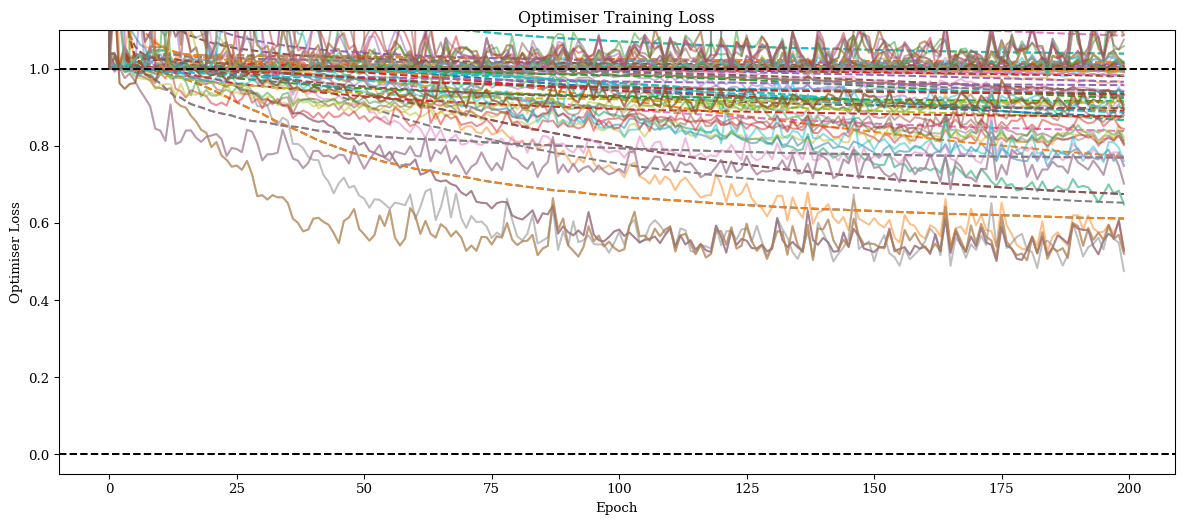

In [22]:
# Define hyperparameters
# NOTE! Compile time scales linearly with the number of hyper parameters, because
# list-comprehensions are used under the hood. This is parallelised under jit, so there
# is no performance hit at runtime.
# As a rough gauge, compile time seemed to be ~1s per hyper parameter combination
hyper_trainer = build_hyper_trainer(
    joint_model, lr=10 ** np.linspace(-3, 2, 11), depth=[0, 1, 2], width=[1, 2]
)

# Train
hyper_trainer, key = hyper_trainer.train_stochastic(
    truth_prior,
    train_prior,
    epochs=200,
    batch_size=1000,
    key=jr.PRNGKey(0),
)

# Plot results
# Note: No legend since we have 99 hyper params
# Note: This can take a long time to run, since it plots all 99 optimisers for all epochs
hyper_trainer.plot_losses(legend=False)  

# Note that the progress-bar displays the best 5 performing optimisers per-epoch

**How easy was that!**

Now lets gets the best of the ensemble and examine both how it performs, and its structure

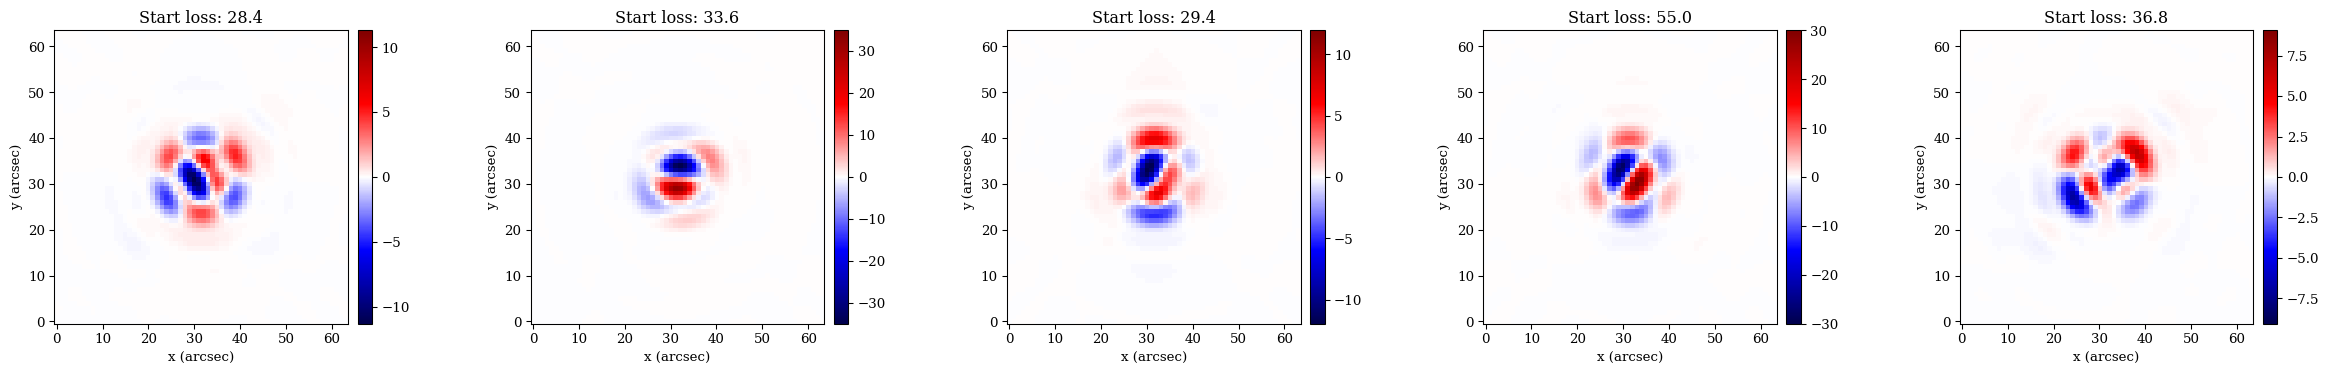

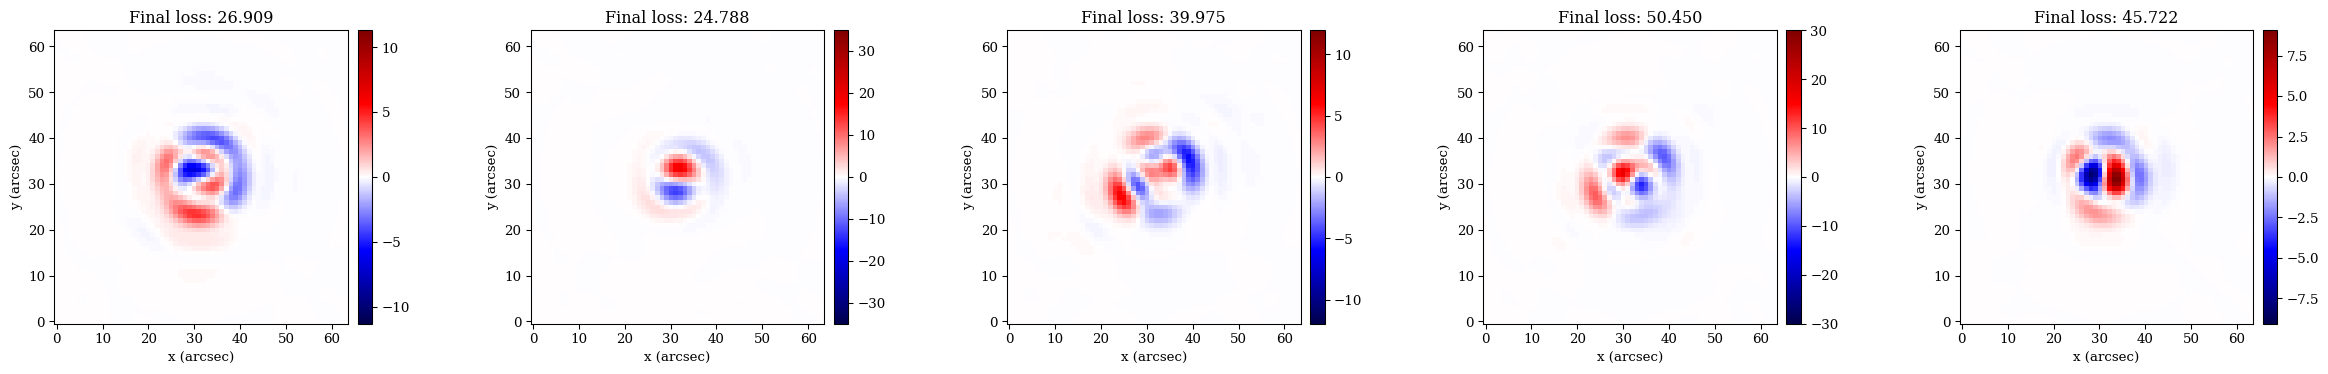

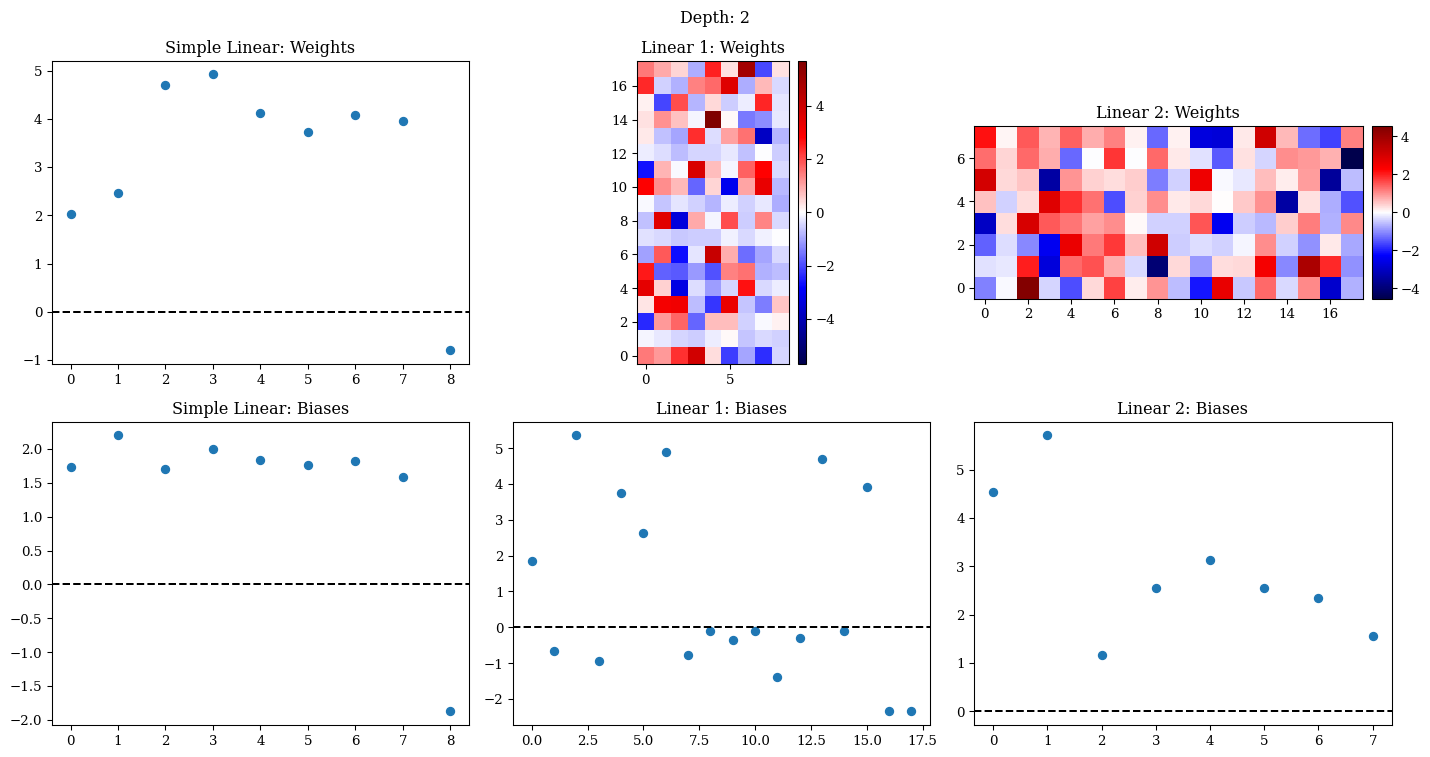

In [50]:
# We can examine the initialisation conditions here if we want
# NOTE: This method has a bug, get the best optimiser like this
joint_model = hyper_trainer.get_top(len(hyper_trainer.hypers))[0]
forge.examine_predictions(joint_model, truth_prior, truth_prior, 1, 5)
forge.visualise_optimiser(joint_model.optimiser)

  0%|          | 0/6 [00:00<?, ?it/s]

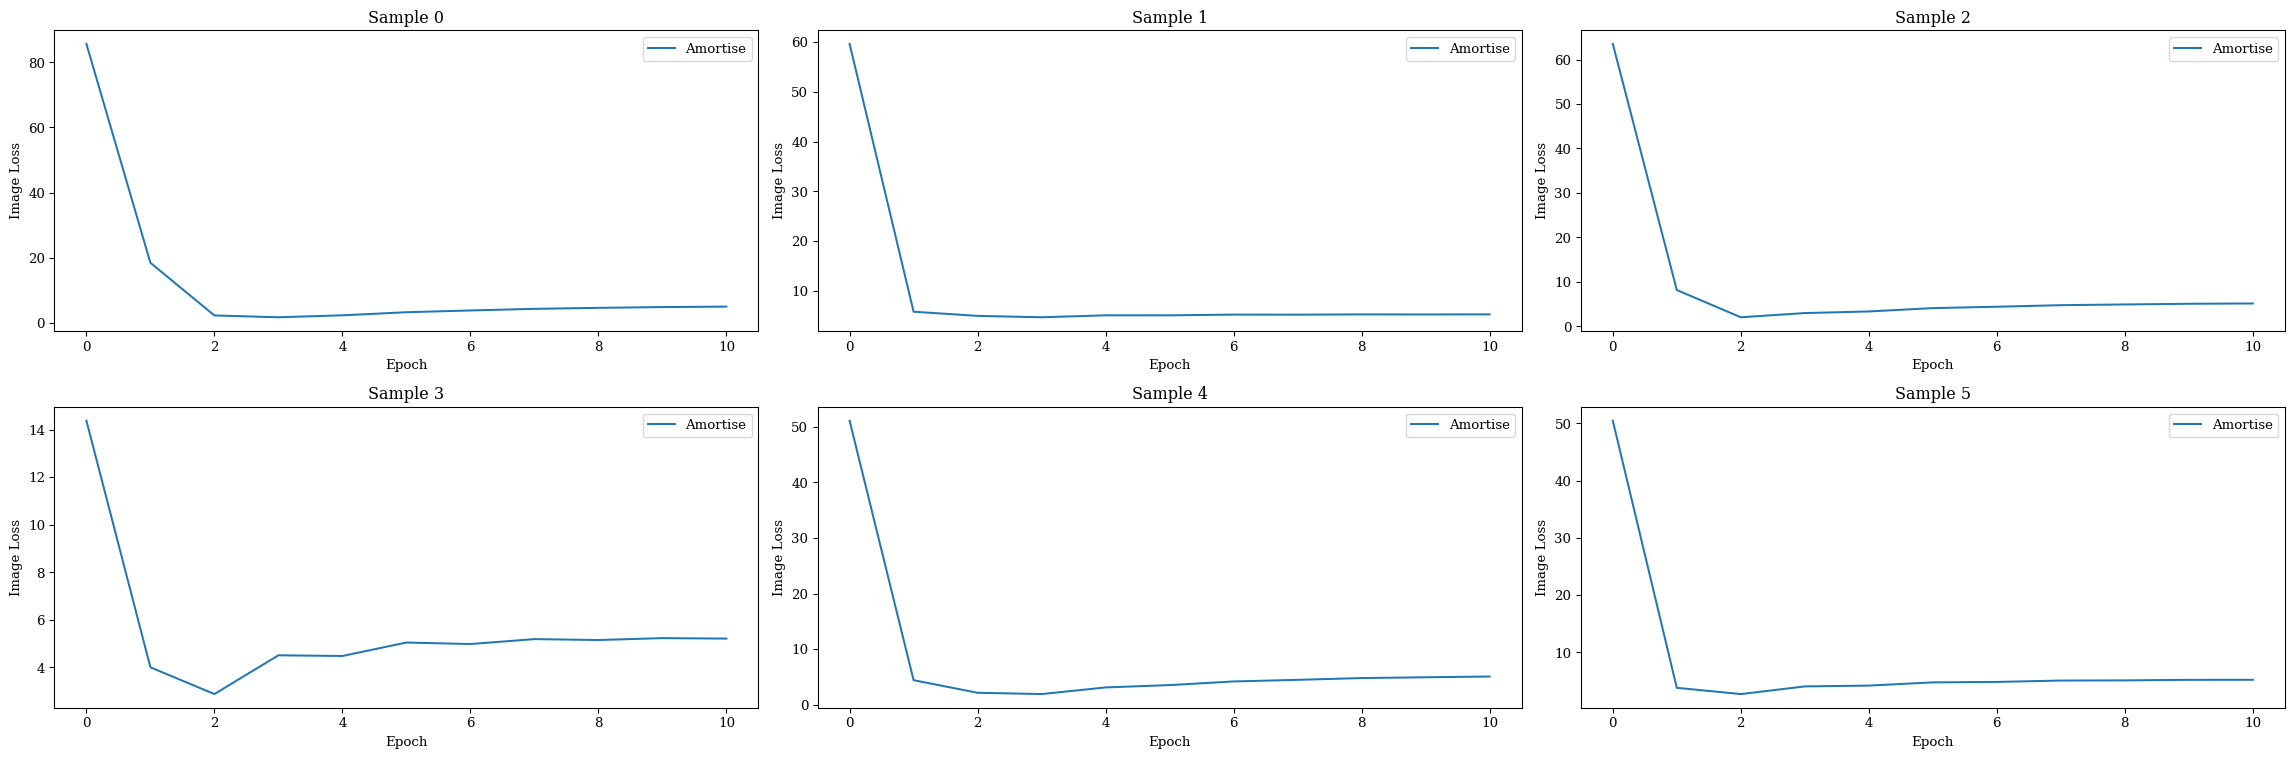

In [53]:
n_samples = 6
truth, key = forge.sample(truth_prior, 1, jr.PRNGKey(0))
samples, key = forge.sample(train_prior, n_samples, key)

psf = joint_model.model_sample(truth)
fig, axes = forge.plot_grid_2d(2, n_samples//2, fsx=8)
for j in tqdm(range(n_samples)):
    # data = jr.poisson(jr.PRNGKey(j), psf)
    data = psf
    pred = samples[0][j]
    
    fmodel = joint_model.fmodel.set(joint_model.params, pred)
    initial_loss = joint_model.image_loss(fmodel, data)

    pred_losses = [initial_loss]
    for i in range(10):
        pred = joint_model.predict(pred, data)
        

        # Get losses
        fmodel = joint_model.fmodel.set(joint_model.params, pred)
        pred_losses.append(joint_model.image_loss(fmodel, data))
    
    axes[j].set(xlabel='Epoch', ylabel='Image Loss', title=f"Sample {j}")
    axes[j].plot(pred_losses, label='Amortise')
    axes[j].legend()
fig.tight_layout()

## Re-Train

As we can see, the optimiser is doing well, but is still struggling with convergence, so we need to train some more.

This is somewhat expected as we only trained for 10 minutes!

Total training PSFs: 800,000
Compiling step function... Done! Took 55.51s


Loss:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch:   0      -0.56%      -0.56%      -0.08%       0.18%       0.00%       0.05%       0.83%       0.83%       0.97%       2.02%       0.26%       4.03%       6.61%       6.61%      11.04%      18.69%       9.12%      19.00%      34.73%      34.73%      23.48%      45.74%      17.81%      18.72%      44.83%      44.83%      25.22%      51.03%      17.74%      23.62%      48.70%      48.70%      10.00%      15.56%       5.09%      13.77%      30.65%      30.65%       9.54%       8.41%      -0.01%      -0.01%      11.59%      11.59%      -0.50%      -0.50%      -0.47%      -0.34%      -1.60%      -1.60%      -1.43%      -1.42%      -1.35%      -1.17%      -1.69%      -1.69%      -1.31%      -1.80%      -1.66%      -1.15%      -6.18%      -6.18%      -9.27%      -5.65%      -5.53%      -5.95%
Epoch:  80      -0.16%      -0.16%       0.04%       0.25%       0.01%       0.14%       1.42%       1.42%       2.86%       5.01%       1.38%       7.32%      11.19%      11.19%      19.09%      2

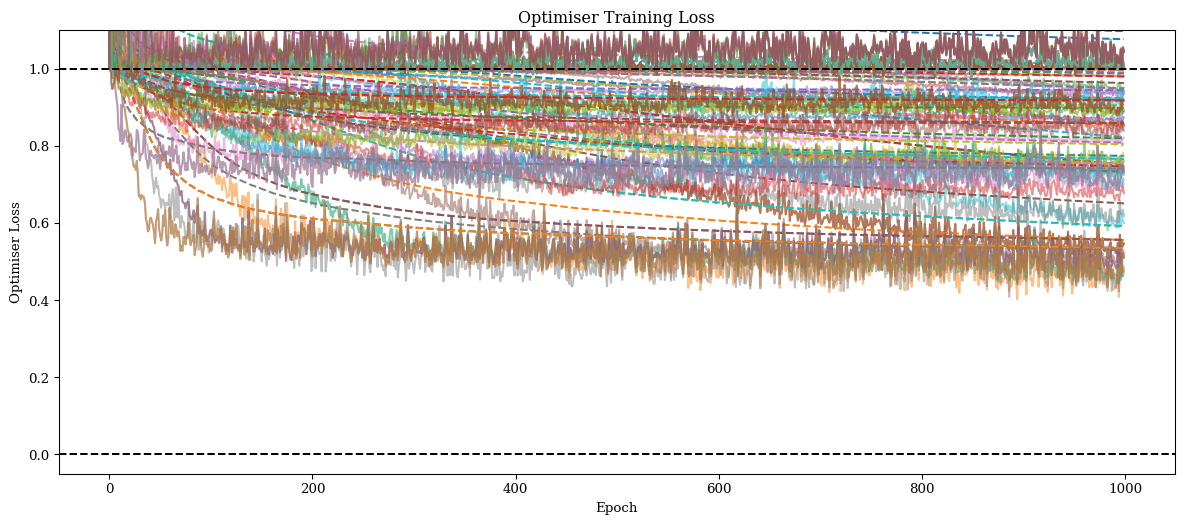

In [54]:
# Re-Train
hyper_trainer, key = hyper_trainer.train_stochastic(
    truth_prior,
    train_prior,
    epochs=800,
    batch_size=1000,
    key=jr.PRNGKey(0),
)

# Plot results
# Note: No legend since we have 99 hyper params
# Note: This can take a long time to run, since it plots all 99 optimisers for all epochs
hyper_trainer.plot_losses(legend=False)  

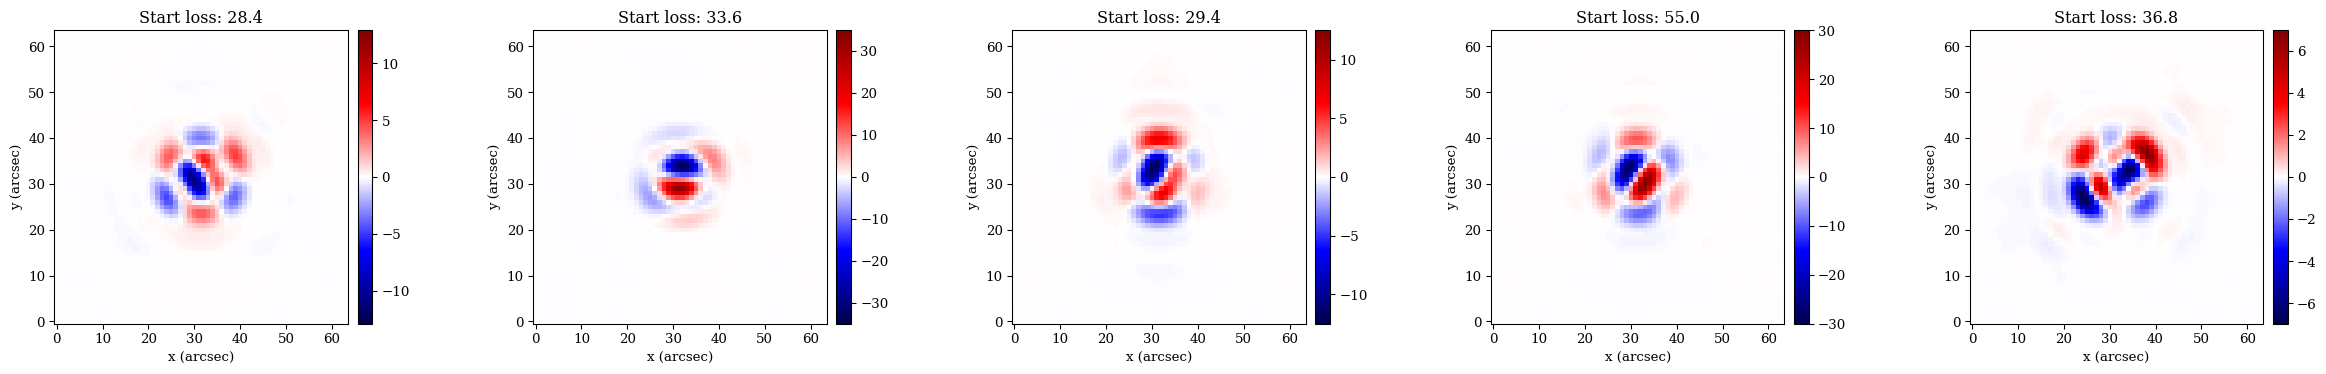

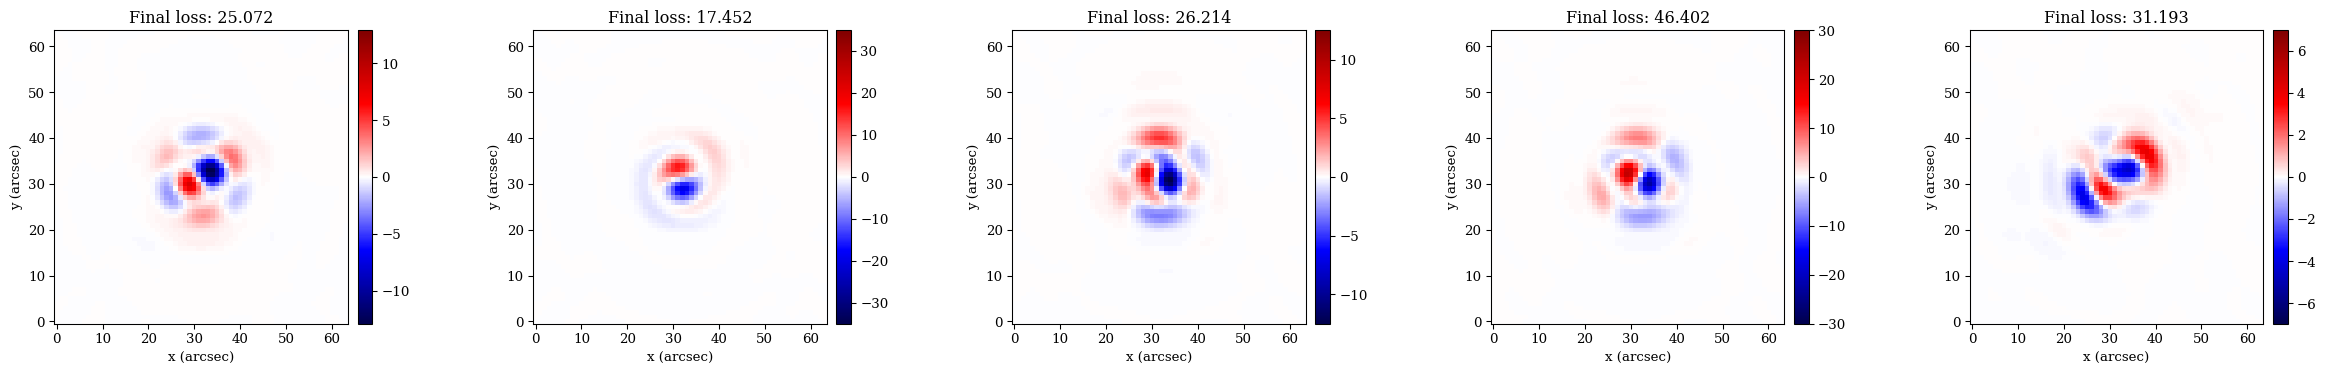

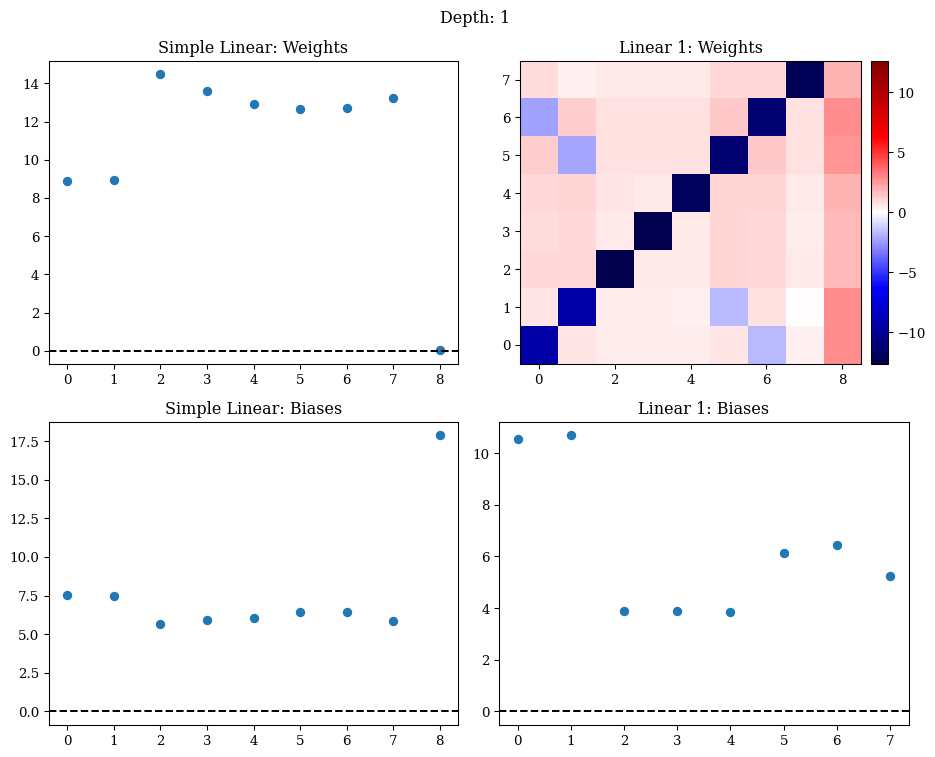

In [66]:
# We can examine the initialisation conditions here if we want
# NOTE: This method has a bug, get the best optimiser like this
joint_model = hyper_trainer.get_top(len(hyper_trainer.hypers))[0]
# joint_model = hyper_trainer.get_top(1)
forge.examine_predictions(joint_model, truth_prior, truth_prior, 1, 5)
forge.visualise_optimiser(joint_model.optimiser)

  0%|          | 0/6 [00:00<?, ?it/s]

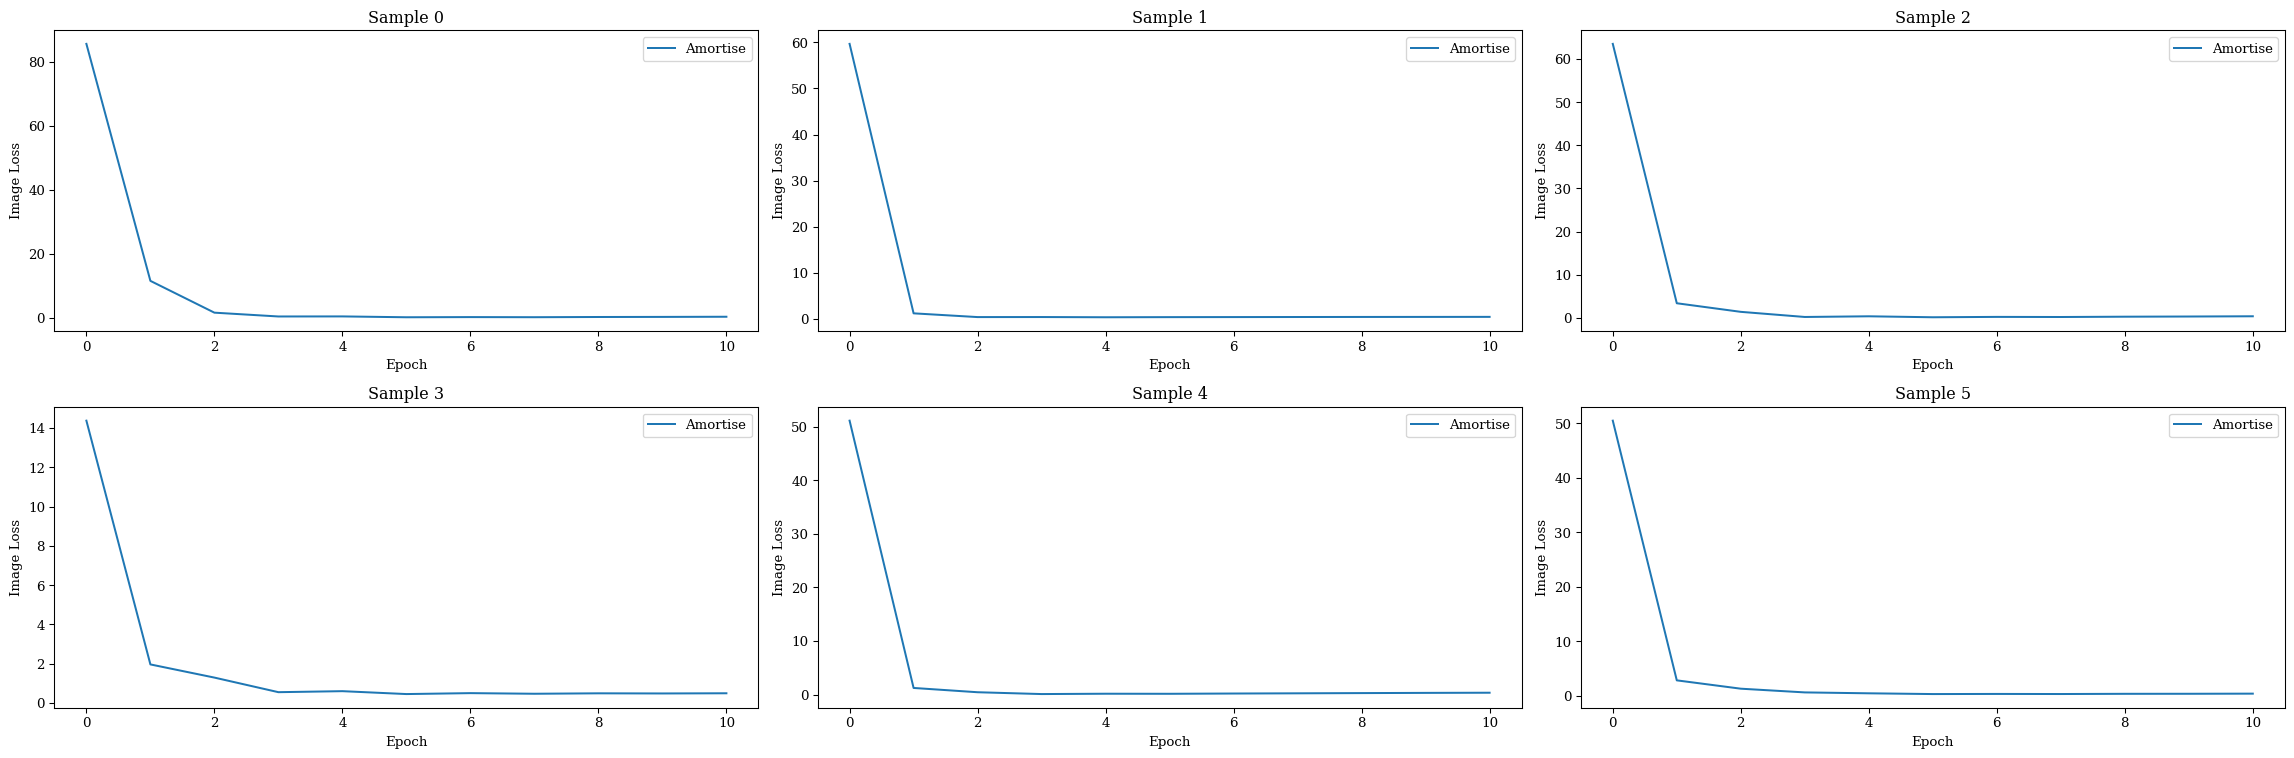

In [56]:
n_samples = 6
truth, key = forge.sample(truth_prior, 1, jr.PRNGKey(0))
samples, key = forge.sample(train_prior, n_samples, key)

psf = joint_model.model_sample(truth)
fig, axes = forge.plot_grid_2d(2, n_samples//2, fsx=8)
for j in tqdm(range(n_samples)):
    # data = jr.poisson(jr.PRNGKey(j), psf)
    data = psf
    pred = samples[0][j]
    
    fmodel = joint_model.fmodel.set(joint_model.params, pred)
    initial_loss = joint_model.image_loss(fmodel, data)

    pred_losses = [initial_loss]
    for i in range(10):
        pred = joint_model.predict(pred, data)
        

        # Get losses
        fmodel = joint_model.fmodel.set(joint_model.params, pred)
        pred_losses.append(joint_model.image_loss(fmodel, data))
    
    axes[j].set(xlabel='Epoch', ylabel='Image Loss', title=f"Sample {j}")
    axes[j].plot(pred_losses, label='Amortise')
    axes[j].legend()
fig.tight_layout()

In [57]:
print(joint_model.optimiser)

MLP(
  layers=[
    SimpleLinear(weight=f32[9], bias=f32[9]),
    Linear(
      weight=f32[8,9],
      bias=f32[8],
      in_features=9,
      out_features=8,
      use_bias=True
    )
  ],
  activation=<wrapped function relu>,
  final_activation=<function <lambda>>,
  use_bias=True,
  use_final_bias=True,
  in_size=9,
  out_size=8,
  width_size=9,
  depth=0
)


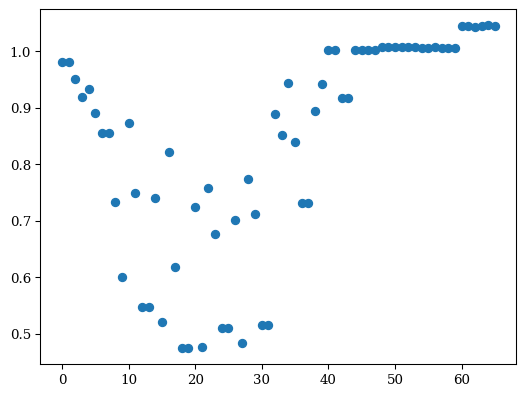

In [59]:
final_losses = hyper_trainer.losses[:, -1]
plt.scatter(np.arange(len(final_losses)), final_losses)